# Cat and Dog Classifier

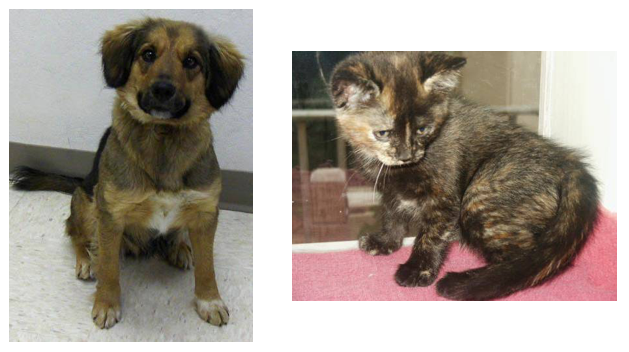

In [2]:
# from IPython.display import Image
# Image('images/dog_cat.png')

In [1]:
import torch # 파이토치 기본 라이브러리 
import torchvision # 이미지 관련 된 파이토치 라이브러리
from torchvision import datasets # 토치비전에서 제공하는 데이터셋
from torchvision import transforms # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader # 데이터를 모델에 사용할 수 있도록 적재해 주는 라이브러리
from torch.utils.data import random_split
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Thu Dec 29 07:18:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 0. 데이터 다운로드

In [ ]:
# option 1
# from google.colab import files
# files.upload()

In [ ]:
# option 2

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# !cp '/content/drive/MyDrive/Classroom/Playdata 인공지능 25기/CNN/kaggle_catanddog.zip' './'

In [ ]:
# !unzip kaggle_catanddog.zip -d catanddog/

In [11]:
data_dir = '../input/cat-and-dog/'

In [6]:
!ls ../input/

cat-and-dog


## 1. 데이터 불러오기

In [ ]:
# Compose 함수를 통해 원하는 전처리를 차례대로 넣을 수 있음
# transform = transforms.Compose([transforms.Resize(16), transforms.ToTensor()])

In [12]:
transform = transforms.Compose([transforms.Resize([224, 224]), transforms.ToTensor()])

In [13]:
trainset = datasets.ImageFolder(root= data_dir + '/training_set/training_set', transform=transform)
testset = datasets.ImageFolder(root= data_dir + '/test_set/test_set', transform=transform)

In [14]:
# trainset을 train용과 valid용으로 나누고 싶을 때
# torch.utils.data.random_split() 사용
# https://pytorch.org/docs/stable/data.html
trainset, validset = random_split(trainset, [7000, 1005])

In [15]:
print(type(trainset), len(trainset))
print(type(validset), len(validset))
print(type(testset), len(testset))

<class 'torch.utils.data.dataset.Subset'> 7000
<class 'torch.utils.data.dataset.Subset'> 1005
<class 'torchvision.datasets.folder.ImageFolder'> 2023


In [16]:
# trainset[0][0] # tensor로 변환된 이미지 데이터
# trainset[0][1] # 이미지 데이터의 라벨(정답)
print(type(trainset[0][0]), type(trainset[0][1]))            

<class 'torch.Tensor'> <class 'int'>


In [17]:
# 일반적으로 opencv, matplotlib 에서 읽어드린 이미지 array는 height * width * channels 형상을 가짐
# 그러나 파이토치로 읽어드린 이미지 텐서는 channels * height * width 형상임을 유의
# 3 x 32 x 232 (3개의 채널에 높이는 32, 너비도 32인 이미지)

In [18]:
# 0번째 샘플 이미지
trainset[0][0].size(), trainset[0][1]

(torch.Size([3, 224, 224]), 0)

In [19]:
# 10번째 샘플 이미지
trainset[10][0].size(), trainset[0][1]

(torch.Size([3, 224, 224]), 0)

## 2. 데이터 시각화

- tensor를 matplotlib에서 표시했을 경우

In [20]:
# 1번 샘플
sample_img = trainset[1][0]
sample_img.size()

torch.Size([3, 224, 224])

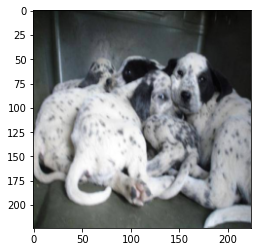

In [21]:
plt.imshow(sample_img.permute(1, 2, 0))

In [22]:
# 1번 샘플의 정답, 0는 cat
trainset[1][1]

1

- numpy로 변환한 뒤 matplotlib으로 표시할 경우

In [23]:
sample_img.size()

torch.Size([3, 224, 224])

In [24]:
numpy_sample = sample_img.numpy()
numpy_sample.shape

(3, 224, 224)

In [25]:
type(numpy_sample)

numpy.ndarray

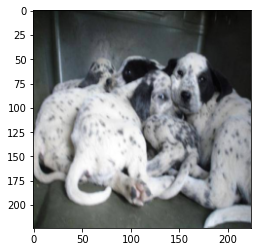

In [26]:
plt.imshow(numpy_sample.transpose(1, 2, 0)) # 차원 순서 변경할 때 tensor는 permute, ndarray는 transpose

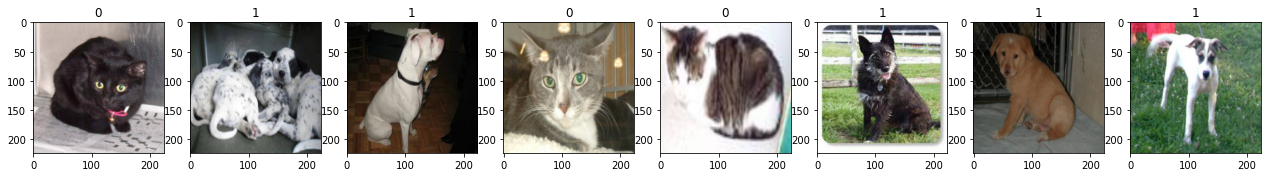

In [27]:
figure, axes = plt.subplots(nrows=1, ncols=8, figsize=(22, 6))
for i in range(8):
  axes[i].imshow(trainset[i][0].permute(1, 2, 0), cmap='gray')
  axes[i].set_title(trainset[i][1])   

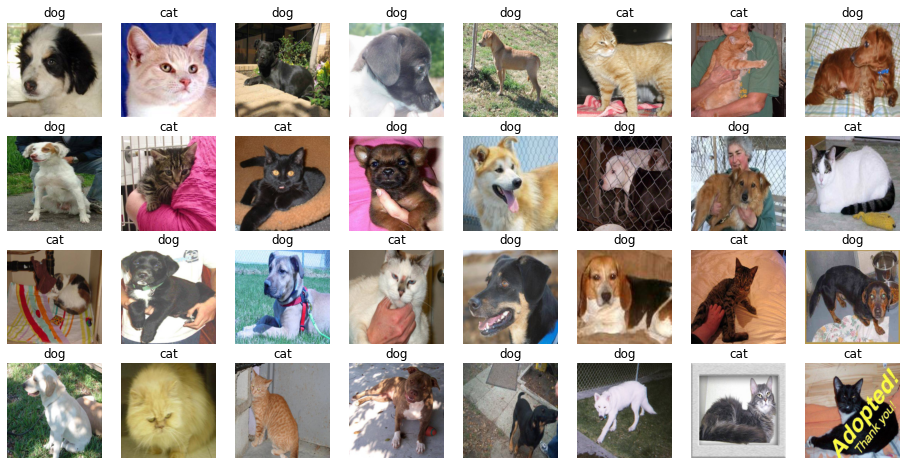

In [28]:
labels_map = {0 : 'cat', 1 : 'dog'}  # for cat and dog  

figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
axes = axes.flatten()

for i in range(32):
    rand_i = np.random.randint(0, len(trainset))
    image = trainset[rand_i][0].permute(1, 2, 0)
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title(labels_map[trainset[rand_i][1]])              

## 3. 데이터 적재

In [29]:
# torch.utils.data.DataLoader
# 데이터를 셔플하거나, 병렬로 데이터를 부르거나, 혹은 미니 배치 작업 단위로 데이터를 준비

In [30]:
40000/16

2500.0

In [31]:
# 배치 사이즈는 중요한 하이퍼 파라미터, 16 이하로 사용하는 것이 성능에 좋다고 알려져 있음
# 배치 사이즈가 크다는 것은 실제 Loss, Gradient, Weight 를 구하는 데 참여하는 데이터가 많다라는 뜻
# 배치 사이즈가 작다는 것은 실제 Loss, Gradient, Weight 를 구하는 데 참여하는 데이터가 작다라는 뜻
# 배치 사이즈가 작으면 실제 모델 학습을 하는데 한번도 보지 않은 신선한 데이터가 제공
# 배치 사이즈가 크면 학습에 참여했던 데이터가 다시 뽑힐 확률이 크고, 1 epoch을 학습하는데도 시간이 적게 걸림
# 배치 사이즈 100일 때는 1 epoch당 학습에 걸리는 횟수가 500회 (훈련 데이터 50,000개 기준)
# 배치 사이즈 16일 때는 1 epoch당 학습에 걸리는 횟수가 3125회 (훈련 데이터 50,000개 기준)
batch_size = 16 # 100 -> 16
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # 훈련용
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False) # 검증용
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False) # 테스트용

In [32]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 438
<class 'torch.utils.data.dataloader.DataLoader'> 63
<class 'torch.utils.data.dataloader.DataLoader'> 127


In [33]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
print(images.size(), labels.size())

torch.Size([16, 3, 224, 224]) torch.Size([16])


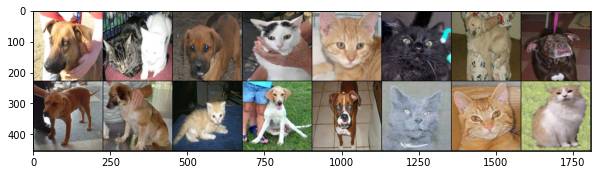

In [34]:
gird_img = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 100))
plt.imshow(gird_img.permute(1, 2, 0))

## 4. 모델 생성

In [35]:
# from IPython.display import Image
# Image('images/알렉스넷.jpg')

In [36]:
# Image('images/알렉스넷2.jpg')

In [37]:
from torch import nn # 파이토치에서 제공하는 다양한 계층(Linear layer, Convolutional Layer...)
from torch import optim # 옵티마이저 (경사하강법...)
import torch.nn.functional as F # 파이토치에서 제공하는 함수(활성화 함수...)

In [38]:
# 가중치 초기화
# 파이토치 문서
# https://pytorch.org/docs/stable/nn.init.html

# 현재 디폴트 값
# Conv : https://github.com/pytorch/pytorch/blob/9cf62a4b5d3b287442e70c0c560a8e21d8c3b189/torch/nn/modules/conv.py#L111
# Linear :
# https://github.com/pytorch/pytorch/blob/9cf62a4b5d3b287442e70c0c560a8e21d8c3b189/torch/nn/modules/linear.py#L168

In [39]:
# 가중치 초기화시 고려할 사항
# 1. 값이 충분히 작아야 함
# 2. 값이 하나로 치우쳐선 안됨
# 3. 적당한 분산으로 골고루 분포가 되어야 함

In [40]:
w = torch.empty(3, 5)
nn.init.kaiming_normal_(w, mode='fan_out', nonlinearity='relu')

tensor([[ 0.5468,  1.0959,  0.0365, -0.3678, -0.5542],
        [ 0.0599,  1.8997, -0.2250, -0.2401,  0.2383],
        [ 0.6994,  0.7910, -1.6580,  0.9915,  0.3299]])

In [41]:
import math
b = torch.empty(3)
bound = 1 / math.sqrt(w.size(1))
nn.init.uniform_(b, -bound, bound)

tensor([-0.2573,  0.4004,  0.2494])

In [42]:
class AlexNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
        # 1st block
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, padding=1),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # 96 x 112 x 112
        # 2nd block
        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # 256 x 56 x 56
        # 3rd block
        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1), nn.BatchNorm2d(384), nn.ReLU(),
        nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1), nn.BatchNorm2d(384), nn.ReLU(),
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # 256 x 28 x 28
    )

    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features=256*28*28, out_features=1024), 
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(in_features=1024, out_features=512), 
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=2)    
    )
  
  def forward(self, x):
    x = self.features(x)
    x = x.view(-1, 256*28*28)  # flatten
    x = self.classifier(x)
    return x

In [43]:
# nn.Module을 상속받아 Class를 만드는 방법 이외에도
# 간단한 망을 구성할 때는 아래와 같이 nn.Sequential을 사용해도 됨
# model = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
#                       nn.ReLU(),
#                       nn.MaxPool2d(kernel_size=2, stride=2), # 32 x 14 x 14

#                       nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
#                       nn.ReLU(),
#                       nn.MaxPool2d(kernel_size=2, stride=2), # 64 x 7 x 7

#                       nn.Flatten(), # 3136 (=64 x 7 x 7)
#                       nn.Linear(in_features=3136, out_features=128),
#                       nn.Linear(in_features=128, out_features=10)) 
# model.to(device)                    

In [44]:
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# nn.CrossEntorpyLoss() 문서에 보면 아래와 같이 언급
# Note that this case is equivalent to the combination of LogSoftmax and NLLLoss. 
# 즉 기존의 Softmax + CrosssEntropy 의 조합이  LogSoftMax + NLLLoss 조합으로 바뀌었음
# 따라서 CrossEntorpyLoss()를 손실함수로 사용하게 되면, 예측을 할 때 softmax() 는 사용하면 안됨

In [45]:
model = AlexNet()
model.to(device)
model


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [46]:
for parameter in model.parameters():
  print(parameter.size())

torch.Size([96, 3, 3, 3])
torch.Size([96])
torch.Size([96])
torch.Size([96])
torch.Size([256, 96, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([384, 256, 3, 3])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([384, 384, 3, 3])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([1024, 200704])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([2, 512])
torch.Size([2])


In [47]:
for name, parameter in model.named_parameters():
  print(name, parameter.size())

features.0.weight torch.Size([96, 3, 3, 3])
features.0.bias torch.Size([96])
features.1.weight torch.Size([96])
features.1.bias torch.Size([96])
features.4.weight torch.Size([256, 96, 3, 3])
features.4.bias torch.Size([256])
features.5.weight torch.Size([256])
features.5.bias torch.Size([256])
features.8.weight torch.Size([384, 256, 3, 3])
features.8.bias torch.Size([384])
features.9.weight torch.Size([384])
features.9.bias torch.Size([384])
features.11.weight torch.Size([384, 384, 3, 3])
features.11.bias torch.Size([384])
features.12.weight torch.Size([384])
features.12.bias torch.Size([384])
features.14.weight torch.Size([256, 384, 3, 3])
features.14.bias torch.Size([256])
features.15.weight torch.Size([256])
features.15.bias torch.Size([256])
classifier.1.weight torch.Size([1024, 200704])
classifier.1.bias torch.Size([1024])
classifier.2.weight torch.Size([1024])
classifier.2.bias torch.Size([1024])
classifier.5.weight torch.Size([512, 1024])
classifier.5.bias torch.Size([512])
clas

In [50]:
!pip install torchsummary

In [51]:
from torchsummary import summary

In [52]:
summary(model, (3, 224, 224)) # (channel, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 224, 224]           2,688
       BatchNorm2d-2         [-1, 96, 224, 224]             192
              ReLU-3         [-1, 96, 224, 224]               0
         MaxPool2d-4         [-1, 96, 112, 112]               0
            Conv2d-5        [-1, 256, 112, 112]         221,440
       BatchNorm2d-6        [-1, 256, 112, 112]             512
              ReLU-7        [-1, 256, 112, 112]               0
         MaxPool2d-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 384, 56, 56]         885,120
      BatchNorm2d-10          [-1, 384, 56, 56]             768
             ReLU-11          [-1, 384, 56, 56]               0
           Conv2d-12          [-1, 384, 56, 56]       1,327,488
      BatchNorm2d-13          [-1, 384, 56, 56]             768
             ReLU-14          [-1, 384,

## 5. 모델 컴파일 (손실함수, 옵티마이저 선택)

In [53]:
learning_rate = 0.001 
# 손실함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저(경사하강법, 최적화 함수)
#optimizer = optim.SGD(model.parameters(), lr = learning_rate)
# 규제의 강도 설정 weight_decay
# optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.001)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [54]:
# Learning Rate Schedule
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

#monitoring 하고 있는 값(valid_loss)이 patience 기간동안(onPlateau) 줄어들지 않을때 lr에 factor(0.1)를 곱해준다.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.1, verbose=True)

## 6. 모델 훈련 (with 검증)

In [55]:
# torch.no_grad()
# https://pytorch.org/docs/stable/generated/torch.no_grad.html
# Context-manager that disabled gradient calculation.

# Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). 
# It will reduce memory consumption for computations that would otherwise have requires_grad=True.

In [56]:
def validation(model, validloader, criterion):
  # 전방향 예측후 나온 점수(logits)의 최대값을 최종 예측으로 준비
  # 이 최종 예측과 정답을 비교
  # 전체 중 맞은 것의 개수 비율을 정확도(accuracy)로 계산
  valid_accuracy = 0
  valid_loss = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음
  with torch.no_grad():
    for images, labels in validloader: # 10000개의 데이터에 대해 16개씩(미니배치 사이즈) 10000/16번을 iterations
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력데이터 준비
      # not Flatten!!
      # images.resize_(images.size()[0], 784) # 16, 1, 28, 28
      
      # 2. 전방향(Forward) 예측 
      logits = model.forward(images) # 점수 반환
      _, preds = torch.max(logits, 1) # 16개에 대한 최종 예측
      # preds= probs.max(dim=1)[1] 
      correct = (preds == labels).sum()

      accuracy = correct / images.shape[0]
      loss = criterion(logits, labels) # 16개에 대한 loss
      
      valid_accuracy += accuracy
      valid_loss += loss.item() # tensor 값을 꺼내옴
    

  return valid_loss, valid_accuracy # validloader 전체 대한 총 loss, 총 accuracy


In [57]:
# 파이토치에서 텐서보드 사용하기
# https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html

In [58]:
from torch.utils.tensorboard import SummaryWriter

writer  = SummaryWriter()

In [59]:
def train(model, epochs, criterion, optimizer):
  steps = 0
  min_loss = 10000
  max_accuracy = 0

  trigger = 0
  patience = 13 # for Early stopping

  # 1 에폭(epoch)당 반복수
  #steps_per_epoch = len(trainset)/batch_size # 2500 iterations
  steps_per_epoch = len(trainloader) # 2500 iterations

  for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, labels in iter(trainloader): # 이터레이터로부터 미니배치 16개씩을 가져와 images, labels에 준비
      steps += 1
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten!!
      # images.resize_(images.size()[0], 784) # 16, 1, 28, 28

      # 2. 전방향(Forward) 예측 
      outputs = model.forward(images) # 예측
      loss = criterion(outputs, labels) # 예측과 결과를 통해 Cross Entropy Loss 반환

      # 3. 역방향(Backward) 오차(Gradient) 전파
      optimizer.zero_grad() # 파이토치에서 gradient가 누적되지 않게 하기 위해
      loss.backward()

      # 4. 경사하강법으로 모델 파라미터 업데이트
      optimizer.step() # W <- W -lr*Gradient

      train_loss += loss.item()
      if (steps % steps_per_epoch) == 0: # step : 2500, .... (epoch 마다)
        model.eval() # 배치 정규화, 드롭아웃이 적용될 때는 model.forward 연산이 training때와 다르므로 반드시 설정
        valid_loss, valid_accuracy = validation(model, validloader, criterion)

        # tensorboad 시각화를 위한 로그 이벤트 등록
        writer.add_scalar("Loss/train", train_loss/len(trainloader), epoch)
        writer.add_scalar("Loss/valid", valid_loss/len(validloader), epoch)
        writer.add_scalars("Loss/train and valid",
                          {'train' : train_loss/len(trainloader),
                          'valid' : valid_loss/len(validloader)}, epoch)
        
        writer.add_scalar("Valid Accuracy", valid_accuracy/len(validloader), epoch)


        print('Epoch : {}/{}.....'.format(epoch+1, epochs),
              'Train Loss : {:.3f}'.format(train_loss/len(trainloader)),
              'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)),
              'Valid Accuracy : {:.3f}'.format(valid_accuracy/len(validloader)))
        
        # Best model 저장
        # option 1
        # if valid_loss < min_loss:
        #   min_loss = valid_loss
        #   torch.save(model.state_dict(), 'best_checkpoint.pth')

        # option 2
        if valid_accuracy > max_accuracy: 
          max_accuracy = valid_accuracy
          torch.save(model.state_dict(), 'best_checkpoint.pth')

        # Early Stopping (조기 종료)
        if valid_loss > min_loss:
          trigger += 1 # valid loss가 min_loss 를 갱신하지 못할때마다 증가
          print('trigger : ', trigger )
          if trigger > patience:
            print('Early Stopping!!!')
            print('Traning step is finished!!')
            writer.flush()  
            return   
        else:
          trigger = 0
          min_loss = valid_loss


        train_loss = 0
        model.train()

        # Learning Rate Scheduler
        scheduler.step(valid_loss)

  writer.flush()      

In [60]:
epochs=55
train(model, epochs, criterion, optimizer)

Epoch : 1/55..... Train Loss : 0.656 Valid Loss : 0.738 Valid Accuracy : 0.602
Epoch : 2/55..... Train Loss : 0.590 Valid Loss : 0.616 Valid Accuracy : 0.682
Epoch : 3/55..... Train Loss : 0.549 Valid Loss : 0.547 Valid Accuracy : 0.717
Epoch : 4/55..... Train Loss : 0.503 Valid Loss : 0.621 Valid Accuracy : 0.676
trigger :  1
Epoch : 5/55..... Train Loss : 0.466 Valid Loss : 0.524 Valid Accuracy : 0.736
Epoch : 6/55..... Train Loss : 0.430 Valid Loss : 0.503 Valid Accuracy : 0.741
Epoch : 7/55..... Train Loss : 0.375 Valid Loss : 0.516 Valid Accuracy : 0.756
trigger :  1
Epoch : 8/55..... Train Loss : 0.336 Valid Loss : 0.556 Valid Accuracy : 0.738
trigger :  2
Epoch : 9/55..... Train Loss : 0.290 Valid Loss : 0.540 Valid Accuracy : 0.755
trigger :  3
Epoch : 10/55..... Train Loss : 0.245 Valid Loss : 0.526 Valid Accuracy : 0.771
trigger :  4
Epoch : 11/55..... Train Loss : 0.230 Valid Loss : 0.536 Valid Accuracy : 0.788
trigger :  5
Epoch : 12/55..... Train Loss : 0.191 Valid Loss : 

In [61]:
%load_ext tensorboard

In [62]:
%tensorboard --logdir=runs

In [63]:
writer.close()

## 7. 모델 예측

In [64]:
test_iter = iter(testloader)
images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)
print(images.size(), labels.size())

torch.Size([16, 3, 224, 224]) torch.Size([16])


In [65]:
rnd_idx = 10
images[rnd_idx:rnd_idx+1].shape, labels[rnd_idx:rnd_idx+1] # 1, 3, 32, 32

(torch.Size([1, 3, 224, 224]), tensor([0], device='cuda:0'))

In [66]:
# not Flatten!
# flattend_img = images[rnd_idx].view(1, 784)
img = images[rnd_idx:rnd_idx+1]
with torch.no_grad():
  model.eval() # 배치 정규화가 들어가면서 전방향 연산이 학습시와는 달라지므로 반드시 eval() 넣어야 함
  logit = model.forward(img)

pred = logit.max(dim=1)[1]
pred == labels[rnd_idx]

tensor([True], device='cuda:0')

In [67]:
pred, labels[rnd_idx] # 예측 4(cat), 정답 0(airplane)

(tensor([0], device='cuda:0'), tensor(0, device='cuda:0'))

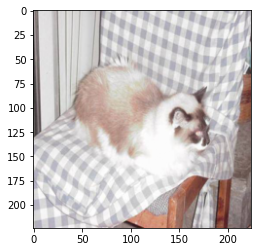

In [68]:
img = img.cpu()
plt.imshow(img[0].permute(1, 2, 0)) 

## 8. 모델 평가

In [69]:
def evaluation(model, testloader, criterion):
  # 전방향 예측후 나온 점수(logits)의 최대값을 최종 예측으로 준비
  # 이 최종 예측과 정답을 비교
  # 전체 중 맞은 것의 개수 비율을 정확도(accuracy)로 계산
  test_accuracy = 0
  test_loss = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음
  with torch.no_grad():
    model.eval()
    for images, labels in testloader: # 10000개의 데이터에 대해 16개씩(미니배치 사이즈) (10000/16)번을 iterations
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력데이터 준비
      # not Flatten!
      # images.resize_(images.size()[0], 784) # 16, 1, 28, 28

      # 2. 전방향(Forward) 예측 
      logits = model.forward(images) # 점수 반환
      _, preds = torch.max(logits, 1) # 16개에 대한 최종 예측
      # preds= probs.max(dim=1)[1] 
      correct = (preds == labels).sum()
      
      accuracy = correct / images.shape[0]
      loss = criterion(logits, labels) # 16개에 대한 loss
      
      test_accuracy += accuracy.item()
      test_loss += loss.item() # tensor 값을 꺼내옴
    

  print('Test Loss : ', test_loss/len(testloader))
  print('Test Accuracy : ', test_accuracy/len(testloader))


In [70]:
evaluation(model, testloader, criterion)

Test Loss :  0.5727490619646283
Test Accuracy :  0.8338723285930363


## 9. 모델 저장# 

In [71]:
# 모델을 저장하는 이유
# 1. 예측을 할 때마다 훈련시키는 것은 비효율적
# 2. 기존 훈련 결과에 이어서 학습을 하고자 할 때

# 파이토치에서 모델 저장하기
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [72]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [73]:
model.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.4.weight', 'features.4.bias', 'features.5.weight', 'features.5.bias', 'features.5.running_mean', 'features.5.running_var', 'features.5.num_batches_tracked', 'features.8.weight', 'features.8.bias', 'features.9.weight', 'features.9.bias', 'features.9.running_mean', 'features.9.running_var', 'features.9.num_batches_tracked', 'features.11.weight', 'features.11.bias', 'features.12.weight', 'features.12.bias', 'features.12.running_mean', 'features.12.running_var', 'features.12.num_batches_tracked', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'classifier.1.weight', 'classifier.1.bias', 'classifier.2.weight', 'classifier.2.bias', 'classifier.2.running_mean', 'classifier.2.running_

In [74]:
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [75]:
last_state_dict = torch.load('last_checkpoint.pth')
last_state_dict.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.4.weight', 'features.4.bias', 'features.5.weight', 'features.5.bias', 'features.5.running_mean', 'features.5.running_var', 'features.5.num_batches_tracked', 'features.8.weight', 'features.8.bias', 'features.9.weight', 'features.9.bias', 'features.9.running_mean', 'features.9.running_var', 'features.9.num_batches_tracked', 'features.11.weight', 'features.11.bias', 'features.12.weight', 'features.12.bias', 'features.12.running_mean', 'features.12.running_var', 'features.12.num_batches_tracked', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'classifier.1.weight', 'classifier.1.bias', 'classifier.2.weight', 'classifier.2.bias', 'classifier.2.running_mean', 'classifier.2.running_

In [76]:
last_model = AlexNet()
last_model.to(device)
last_model.load_state_dict(last_state_dict)

<All keys matched successfully>

In [77]:
evaluation(last_model, testloader, criterion)

Test Loss :  0.5727490619646283
Test Accuracy :  0.8338723285930363


In [78]:
best_state_dict = torch.load('best_checkpoint.pth')

In [79]:
best_model = AlexNet()
best_model.to(device)
best_model.load_state_dict(best_state_dict)


<All keys matched successfully>

In [80]:
evaluation(best_model, testloader, criterion)

Test Loss :  0.5437770660995968
Test Accuracy :  0.8251546687028539
